[参考](https://qiita.com/nymwa/items/9c8484ff511123e03ba8)

# 70

In [1]:
import os
import re
import spacy
import numpy as np
from gensim.models import KeyedVectors
import tensorflow as tf
import codecs
import pickle

In [2]:
nlp = spacy.load('en')
categories = ['b', 't', 'e', 'm']
category_names = ['business', 'science and technology', 'entertainment', 'health']

In [3]:
def tokenize(x):
    x = re.sub(r'\s+', ' ', x)
    x = nlp.make_doc(x)
    x = [d.text for d in x]
    return x

def read_feature_dataset(filename):
    with open(filename) as f:
        dataset = f.read().splitlines()
    dataset = [line.split('\t') for line in dataset]
    t_index = [categories.index(line[0]) for line in dataset]
    dataset_t = []
    for index in t_index:
        label = [0]*4
        label[index] = 1
        dataset_t.append(label)
    dataset_x = [tokenize(line[1]) for line in dataset]
    return dataset_x, dataset_t

In [4]:
train_x, train_t = read_feature_dataset('train.txt')
valid_x, valid_t = read_feature_dataset('valid.txt')
test_x, test_t = read_feature_dataset('test.txt')

In [5]:
model = KeyedVectors.load('GoogleNews-vectors-negative300.kv', mmap='r')

In [6]:
model

### tenosrflowでいきます

In [7]:
def sent_to_vector(sent):
    lst = [tf.constant(model[token]) for token in sent if token in model]
    return sum(lst) / len(lst)

def dataset_to_vector(dataset):
    return tf.stack([sent_to_vector(x) for x in dataset])

In [8]:
train_v = dataset_to_vector(train_x)
valid_v = dataset_to_vector(valid_x)
test_v = dataset_to_vector(test_x)

In [9]:
train_t = tf.constant(train_t)
valid_t = tf.constant(valid_t)
test_t = tf.constant(test_t)

In [10]:
train_t[0]

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([0, 1, 0, 0], dtype=int32)>

In [11]:
with open('data/train.feature.pickle', 'wb') as f:
    pickle.dump(train_v, f)
with open('data/train.label.pickle', 'wb') as f:
    pickle.dump(train_t, f)

with open('data/valid.feature.pickle', 'wb') as f:
    pickle.dump(valid_v, f)
with open('data/valid.label.pickle', 'wb') as f:
    pickle.dump(valid_t, f)

with open('data/test.feature.pickle', 'wb') as f:
    pickle.dump(test_v, f)
with open('data/test.label.pickle', 'wb') as f:
    pickle.dump(test_t, f)

# 71

In [12]:
train_v.shape

TensorShape([10684, 300])

In [10]:
class NN(tf.keras.Model):
    def __init__(self, out_dim, name="NN"):
        super().__init__(name=name)
        self.out_dim = out_dim
        self.l1 = tf.keras.layers.Dense(
            self.out_dim, 
            use_bias=False, 
        )

    def call(self, x):
        y = self.l1(x)
        return y

In [14]:
model = NN(4)

In [15]:
x = model(train_v[:4])
y = tf.nn.softmax(x, axis=1)
print(y)

tf.Tensor(
[[0.27105638 0.21025594 0.2768963  0.24179135]
 [0.25923803 0.22998773 0.2519572  0.258817  ]
 [0.25618827 0.23317808 0.27294967 0.23768398]
 [0.26645193 0.24657838 0.25155726 0.23541252]], shape=(4, 4), dtype=float32)


# 72

In [36]:
class NN(tf.keras.Model):
    def __init__(self, out_dim, name="NN"):
        super().__init__(name=name)
        self.out_dim = out_dim
        self.l1 = tf.keras.layers.Dense(
            self.out_dim, 
            use_bias=False, 
        )

    def call(self, x):
        y = tf.nn.softmax(self.l1(x))
        return y

In [17]:
model = NN(4)

In [37]:
def loss(t, y):
    return tf.keras.backend.mean(tf.keras.losses.categorical_crossentropy(t,y))

In [32]:
loss(train_t, model(train_v))

<tf.Tensor: shape=(), dtype=float32, numpy=1.3917322>

In [38]:
model.weights

[<tf.Variable 'NN_3/dense_3/kernel:0' shape=(300, 4) dtype=float32, numpy=
 array([[-0.14557539,  0.11823332,  0.34058216, -0.16903909],
        [-0.02411027, -0.02279511,  0.02591159, -0.02887959],
        [-0.17186394,  0.23045748, -0.4667877 ,  0.30230948],
        ...,
        [ 0.32950136, -0.11474972, -0.2505173 ,  0.20788379],
        [ 0.22107084, -0.17142977, -0.10495279,  0.15617962],
        [-0.33674183,  0.02062605,  0.28764173,  0.26345536]],
       dtype=float32)>]

In [21]:
with tf.GradientTape() as t:
    current_loss = loss(train_t, model(train_v))
dW = t.gradient(current_loss, [model.weights])

In [22]:
print('損失', loss(train_t, model(train_v)).numpy())
print('勾配', dW)

損失 1.3971515
勾配 [[<tf.Tensor: shape=(300, 4), dtype=float32, numpy=
array([[ 0.00237833,  0.00236302, -0.01105221,  0.00631086],
       [-0.00366788,  0.00325024, -0.00487128,  0.00528892],
       [ 0.0034686 , -0.00655841,  0.01188552, -0.00879571],
       ...,
       [-0.00998964, -0.00032125,  0.01252372, -0.00221283],
       [-0.01262435,  0.00839224, -0.00363734,  0.00786945],
       [ 0.01333076, -0.00208912, -0.00507838, -0.00616326]],
      dtype=float32)>]]


# 73

In [23]:
model = NN(4)

In [24]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
              loss=loss,
              metrics=['accuracy']
             )

In [25]:
history = model.fit(train_v,train_t,
                    epochs=20, 
                    validation_data=(valid_v, valid_t),
                    verbose=2
                   )

Train on 10684 samples, validate on 1336 samples
Epoch 1/20
10684/10684 - 1s - loss: 0.8857 - accuracy: 0.7507 - val_loss: 0.7018 - val_accuracy: 0.7747
Epoch 2/20
10684/10684 - 1s - loss: 0.6422 - accuracy: 0.7826 - val_loss: 0.5859 - val_accuracy: 0.7889
Epoch 3/20
10684/10684 - 1s - loss: 0.5596 - accuracy: 0.8003 - val_loss: 0.5235 - val_accuracy: 0.8136
Epoch 4/20
10684/10684 - 1s - loss: 0.5095 - accuracy: 0.8228 - val_loss: 0.4826 - val_accuracy: 0.8308
Epoch 5/20
10684/10684 - 1s - loss: 0.4748 - accuracy: 0.8373 - val_loss: 0.4536 - val_accuracy: 0.8413
Epoch 6/20
10684/10684 - 1s - loss: 0.4490 - accuracy: 0.8498 - val_loss: 0.4311 - val_accuracy: 0.8563
Epoch 7/20
10684/10684 - 1s - loss: 0.4291 - accuracy: 0.8595 - val_loss: 0.4145 - val_accuracy: 0.8585
Epoch 8/20
10684/10684 - 1s - loss: 0.4132 - accuracy: 0.8646 - val_loss: 0.4008 - val_accuracy: 0.8690
Epoch 9/20
10684/10684 - 1s - loss: 0.4001 - accuracy: 0.8692 - val_loss: 0.3893 - val_accuracy: 0.8735
Epoch 10/20
106

# 74

In [13]:
def acc(t,y):
    return tf.keras.backend.mean(tf.keras.metrics.categorical_accuracy(t,y))

In [27]:
print('学習データでの正解率 :', acc(train_t, model(train_v)).numpy())
print('評価データでの正解率 :', acc(valid_t, model(valid_v)).numpy())

学習データでの正解率 : 0.8940472
評価データでの正解率 : 0.88622755


# 75

In [28]:
model = NN(4)
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
              loss=loss,
              metrics=['accuracy']
             )

In [29]:
print('学習データでの正解率 :', acc(train_t, model(train_v)).numpy())
print('評価データでの正解率 :', acc(valid_t, model(valid_v)).numpy())

学習データでの正解率 : 0.26516286
評価データでの正解率 : 0.2769461


In [30]:
model.summary()

Model: "NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              multiple                  1200      
Total params: 1,200
Trainable params: 1,200
Non-trainable params: 0
_________________________________________________________________


In [31]:
history = model.fit(train_v,train_t,
                    epochs=200, 
                    validation_data=(valid_v, valid_t),
                    verbose=2
                   )

Train on 10684 samples, validate on 1336 samples
Epoch 1/200
10684/10684 - 1s - loss: 0.8805 - accuracy: 0.7545 - val_loss: 0.6985 - val_accuracy: 0.7769
Epoch 2/200
10684/10684 - 1s - loss: 0.6405 - accuracy: 0.7822 - val_loss: 0.5837 - val_accuracy: 0.7867
Epoch 3/200
10684/10684 - 1s - loss: 0.5586 - accuracy: 0.8029 - val_loss: 0.5223 - val_accuracy: 0.8106
Epoch 4/200
10684/10684 - 1s - loss: 0.5089 - accuracy: 0.8219 - val_loss: 0.4817 - val_accuracy: 0.8293
Epoch 5/200
10684/10684 - 1s - loss: 0.4745 - accuracy: 0.8399 - val_loss: 0.4531 - val_accuracy: 0.8413
Epoch 6/200
10684/10684 - 1s - loss: 0.4489 - accuracy: 0.8517 - val_loss: 0.4314 - val_accuracy: 0.8548
Epoch 7/200
10684/10684 - 1s - loss: 0.4290 - accuracy: 0.8599 - val_loss: 0.4139 - val_accuracy: 0.8638
Epoch 8/200
10684/10684 - 1s - loss: 0.4132 - accuracy: 0.8644 - val_loss: 0.4006 - val_accuracy: 0.8683
Epoch 9/200
10684/10684 - 1s - loss: 0.4001 - accuracy: 0.8688 - val_loss: 0.3894 - val_accuracy: 0.8720
Epoch 

Epoch 78/200
10684/10684 - 1s - loss: 0.2672 - accuracy: 0.9109 - val_loss: 0.2850 - val_accuracy: 0.9027
Epoch 79/200
10684/10684 - 1s - loss: 0.2668 - accuracy: 0.9114 - val_loss: 0.2847 - val_accuracy: 0.9027
Epoch 80/200
10684/10684 - 1s - loss: 0.2663 - accuracy: 0.9113 - val_loss: 0.2844 - val_accuracy: 0.9019
Epoch 81/200
10684/10684 - 1s - loss: 0.2659 - accuracy: 0.9115 - val_loss: 0.2843 - val_accuracy: 0.9027
Epoch 82/200
10684/10684 - 1s - loss: 0.2654 - accuracy: 0.9115 - val_loss: 0.2840 - val_accuracy: 0.9042
Epoch 83/200
10684/10684 - 1s - loss: 0.2651 - accuracy: 0.9126 - val_loss: 0.2839 - val_accuracy: 0.9034
Epoch 84/200
10684/10684 - 1s - loss: 0.2647 - accuracy: 0.9119 - val_loss: 0.2837 - val_accuracy: 0.9034
Epoch 85/200
10684/10684 - 0s - loss: 0.2643 - accuracy: 0.9122 - val_loss: 0.2836 - val_accuracy: 0.9042
Epoch 86/200
10684/10684 - 1s - loss: 0.2639 - accuracy: 0.9122 - val_loss: 0.2832 - val_accuracy: 0.9027
Epoch 87/200
10684/10684 - 1s - loss: 0.2635 -

Epoch 155/200
10684/10684 - 0s - loss: 0.2462 - accuracy: 0.9179 - val_loss: 0.2760 - val_accuracy: 0.9072
Epoch 156/200
10684/10684 - 0s - loss: 0.2460 - accuracy: 0.9172 - val_loss: 0.2761 - val_accuracy: 0.9072
Epoch 157/200
10684/10684 - 0s - loss: 0.2459 - accuracy: 0.9176 - val_loss: 0.2759 - val_accuracy: 0.9072
Epoch 158/200
10684/10684 - 0s - loss: 0.2457 - accuracy: 0.9169 - val_loss: 0.2759 - val_accuracy: 0.9072
Epoch 159/200
10684/10684 - 0s - loss: 0.2456 - accuracy: 0.9168 - val_loss: 0.2758 - val_accuracy: 0.9072
Epoch 160/200
10684/10684 - 0s - loss: 0.2454 - accuracy: 0.9172 - val_loss: 0.2757 - val_accuracy: 0.9072
Epoch 161/200
10684/10684 - 0s - loss: 0.2452 - accuracy: 0.9174 - val_loss: 0.2757 - val_accuracy: 0.9072
Epoch 162/200
10684/10684 - 0s - loss: 0.2451 - accuracy: 0.9169 - val_loss: 0.2756 - val_accuracy: 0.9072
Epoch 163/200
10684/10684 - 1s - loss: 0.2449 - accuracy: 0.9169 - val_loss: 0.2756 - val_accuracy: 0.9072
Epoch 164/200
10684/10684 - 1s - loss

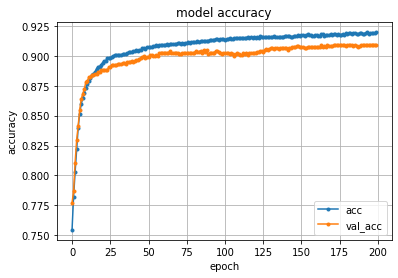

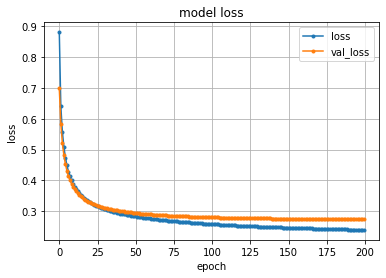

In [32]:
import matplotlib.pyplot as plt

# 精度のplot
plt.plot(history.history['accuracy'], marker='.', label='acc')
plt.plot(history.history['val_accuracy'], marker='.', label='val_acc')
plt.title('model accuracy')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.show()

# 損失のplot
plt.plot(history.history['loss'], marker='.', label='loss')
plt.plot(history.history['val_loss'], marker='.', label='val_loss')
plt.title('model loss')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='best')
plt.show()

In [33]:
model = NN(4)
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss=loss,
              metrics=['accuracy']
             )

In [34]:
epochs = 500

In [36]:
!rm -r ./log

rm: ./log: No such file or directory


In [37]:
tb_cb = tf.keras.callbacks.TensorBoard(
    log_dir='./log/',
    histogram_freq=1,
    write_images=True
)

In [38]:
%reload_ext tensorboard
%tensorboard  --logdir log --bind_all  --reload_multifile true

In [39]:
history = model.fit(train_v,train_t,
                    epochs=epochs, 
                    validation_data=(valid_v, valid_t),
                    verbose=0,
                    callbacks=[tb_cb]
                   )

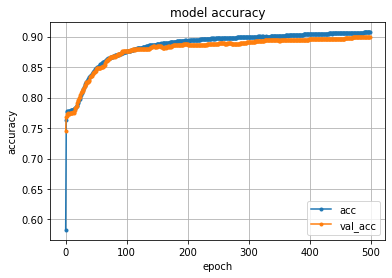

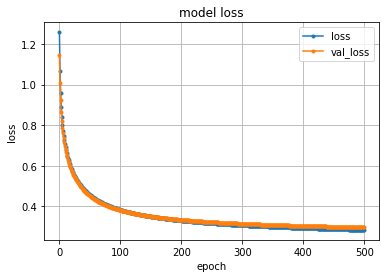

In [41]:
# 精度のplot
plt.plot(history.history['accuracy'], marker='.', label='acc')
plt.plot(history.history['val_accuracy'], marker='.', label='val_acc')
plt.title('model accuracy')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.show()

# 損失のplot
plt.plot(history.history['loss'], marker='.', label='loss')
plt.plot(history.history['val_loss'], marker='.', label='val_loss')
plt.title('model loss')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='best')
plt.show()

# 76

In [16]:
f_model = './model'

In [17]:
model = NN(4)
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss=loss,
              metrics=['accuracy']
             )

In [18]:
!rm -r ./log
!rm -r ./model/checkpoint

In [19]:
tb_cb = tf.keras.callbacks.TensorBoard(
    log_dir='./log/',
    histogram_freq=1,
    write_images=True
)

In [20]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "./model/checkpoint/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    period=5)


In [99]:
%reload_ext tensorboard
%tensorboard --logdir log --bind_all --reload_multifile true

In [22]:
history = model.fit(train_v,train_t,
                    epochs=200, 
                    validation_data=(valid_v, valid_t),
                    verbose=1,
                    callbacks=[tb_cb, cp_callback]
                   )

Train on 10684 samples, validate on 1336 samples
Epoch 1/200
10684/10684 [==============================] - 1s 110us/sample - loss: 1.2183 - accuracy: 0.6822 - val_loss: 1.1110 - val_accuracy: 0.7620
Epoch 2/200
10684/10684 [==============================] - 1s 84us/sample - loss: 1.0411 - accuracy: 0.7745 - val_loss: 0.9842 - val_accuracy: 0.7702
Epoch 3/200
10684/10684 [==============================] - 1s 71us/sample - loss: 0.9419 - accuracy: 0.7786 - val_loss: 0.9058 - val_accuracy: 0.7710
Epoch 4/200
10684/10684 [==============================] - 1s 70us/sample - loss: 0.8772 - accuracy: 0.7792 - val_loss: 0.8511 - val_accuracy: 0.7710
Epoch 5/200
 9984/10684 [===========================>..] - ETA: 0s - loss: 0.8331 - accuracy: 0.7783
Epoch 00005: saving model to ./model/checkpoint/cp-0005.ckpt
10684/10684 [==============================] - 1s 89us/sample - loss: 0.8306 - accuracy: 0.7797 - val_loss: 0.8099 - val_accuracy: 0.7732
Epoch 6/200
10684/10684 [=========================

Epoch 46/200
10684/10684 [==============================] - 1s 71us/sample - loss: 0.4691 - accuracy: 0.8425 - val_loss: 0.4600 - val_accuracy: 0.8413
Epoch 47/200
10684/10684 [==============================] - 1s 64us/sample - loss: 0.4663 - accuracy: 0.8442 - val_loss: 0.4573 - val_accuracy: 0.8436
Epoch 48/200
10684/10684 [==============================] - 1s 104us/sample - loss: 0.4636 - accuracy: 0.8458 - val_loss: 0.4547 - val_accuracy: 0.8443
Epoch 49/200
10684/10684 [==============================] - 1s 126us/sample - loss: 0.4610 - accuracy: 0.8464 - val_loss: 0.4522 - val_accuracy: 0.8458
Epoch 50/200
10272/10684 [===========================>..] - ETA: 0s - loss: 0.4594 - accuracy: 0.8466
Epoch 00050: saving model to ./model/checkpoint/cp-0050.ckpt
10684/10684 [==============================] - 1s 99us/sample - loss: 0.4584 - accuracy: 0.8469 - val_loss: 0.4497 - val_accuracy: 0.8481
Epoch 51/200
10684/10684 [==============================] - 1s 100us/sample - loss: 0.4560 - 

10684/10684 [==============================] - 1s 74us/sample - loss: 0.3919 - accuracy: 0.8739 - val_loss: 0.3862 - val_accuracy: 0.8720
Epoch 92/200
10684/10684 [==============================] - 1s 64us/sample - loss: 0.3909 - accuracy: 0.8741 - val_loss: 0.3852 - val_accuracy: 0.8728
Epoch 93/200
10684/10684 [==============================] - 1s 63us/sample - loss: 0.3898 - accuracy: 0.8750 - val_loss: 0.3843 - val_accuracy: 0.8735
Epoch 94/200
10684/10684 [==============================] - 1s 66us/sample - loss: 0.3888 - accuracy: 0.8751 - val_loss: 0.3833 - val_accuracy: 0.8743
Epoch 95/200
10240/10684 [===========================>..] - ETA: 0s - loss: 0.3863 - accuracy: 0.8765
Epoch 00095: saving model to ./model/checkpoint/cp-0095.ckpt
10684/10684 [==============================] - 1s 66us/sample - loss: 0.3878 - accuracy: 0.8755 - val_loss: 0.3824 - val_accuracy: 0.8743
Epoch 96/200
10684/10684 [==============================] - 1s 69us/sample - loss: 0.3869 - accuracy: 0.8760

Epoch 136/200
10684/10684 [==============================] - 1s 72us/sample - loss: 0.3571 - accuracy: 0.8851 - val_loss: 0.3543 - val_accuracy: 0.8810
Epoch 137/200
10684/10684 [==============================] - 1s 63us/sample - loss: 0.3565 - accuracy: 0.8852 - val_loss: 0.3538 - val_accuracy: 0.8810
Epoch 138/200
10684/10684 [==============================] - 1s 70us/sample - loss: 0.3560 - accuracy: 0.8854 - val_loss: 0.3533 - val_accuracy: 0.8810
Epoch 139/200
10684/10684 [==============================] - 1s 65us/sample - loss: 0.3554 - accuracy: 0.8856 - val_loss: 0.3528 - val_accuracy: 0.8817
Epoch 140/200
 9856/10684 [==========================>...] - ETA: 0s - loss: 0.3526 - accuracy: 0.8876
Epoch 00140: saving model to ./model/checkpoint/cp-0140.ckpt
10684/10684 [==============================] - 1s 63us/sample - loss: 0.3549 - accuracy: 0.8857 - val_loss: 0.3523 - val_accuracy: 0.8817
Epoch 141/200
10684/10684 [==============================] - 1s 70us/sample - loss: 0.3543

Epoch 181/200
10684/10684 [==============================] - 1s 75us/sample - loss: 0.3365 - accuracy: 0.8923 - val_loss: 0.3361 - val_accuracy: 0.8877
Epoch 182/200
10684/10684 [==============================] - 1s 64us/sample - loss: 0.3362 - accuracy: 0.8926 - val_loss: 0.3358 - val_accuracy: 0.8877
Epoch 183/200
10684/10684 [==============================] - 1s 67us/sample - loss: 0.3358 - accuracy: 0.8925 - val_loss: 0.3355 - val_accuracy: 0.8885
Epoch 184/200
10684/10684 [==============================] - 1s 67us/sample - loss: 0.3355 - accuracy: 0.8925 - val_loss: 0.3352 - val_accuracy: 0.8877
Epoch 185/200
 9856/10684 [==========================>...] - ETA: 0s - loss: 0.3349 - accuracy: 0.8927
Epoch 00185: saving model to ./model/checkpoint/cp-0185.ckpt
10684/10684 [==============================] - 1s 63us/sample - loss: 0.3351 - accuracy: 0.8928 - val_loss: 0.3349 - val_accuracy: 0.8877
Epoch 186/200
10684/10684 [==============================] - 1s 72us/sample - loss: 0.3347

In [23]:
! ls {checkpoint_dir}

checkpoint                       cp-0105.ckpt.data-00000-of-00001
cp-0005.ckpt.data-00000-of-00001 cp-0105.ckpt.index
cp-0005.ckpt.index               cp-0110.ckpt.data-00000-of-00001
cp-0010.ckpt.data-00000-of-00001 cp-0110.ckpt.index
cp-0010.ckpt.index               cp-0115.ckpt.data-00000-of-00001
cp-0015.ckpt.data-00000-of-00001 cp-0115.ckpt.index
cp-0015.ckpt.index               cp-0120.ckpt.data-00000-of-00001
cp-0020.ckpt.data-00000-of-00001 cp-0120.ckpt.index
cp-0020.ckpt.index               cp-0125.ckpt.data-00000-of-00001
cp-0025.ckpt.data-00000-of-00001 cp-0125.ckpt.index
cp-0025.ckpt.index               cp-0130.ckpt.data-00000-of-00001
cp-0030.ckpt.data-00000-of-00001 cp-0130.ckpt.index
cp-0030.ckpt.index               cp-0135.ckpt.data-00000-of-00001
cp-0035.ckpt.data-00000-of-00001 cp-0135.ckpt.index
cp-0035.ckpt.index               cp-0140.ckpt.data-00000-of-00001
cp-0040.ckpt.data-00000-of-00001 cp-0140.ckpt.index
cp-0040.ckpt.index               cp-0145.ckpt.data-00000

In [25]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'./model/checkpoint/cp-0200.ckpt'

In [26]:
model = NN(4)
model.load_weights(latest)
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss=loss,
              metrics=['accuracy']
             )

loss, acc = model.evaluate(test_v,  test_t, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

1336/1336 - 0s - loss: 0.3088 - accuracy: 0.8982
Restored model, accuracy: 89.82%


# 77

In [45]:
from time import time
from contextlib import contextmanager

In [46]:
@contextmanager
def timer(description):
    start = time()
    yield
    print(description, ': {:.3f} 秒'.format(time()-start))

In [47]:
B = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

In [48]:
epochs = 1

In [49]:
for b in B:
    model = NN(4)
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss=loss,
              metrics=['accuracy']
             )
    with timer(f'バッチサイズ {b}'):
        history = model.fit(train_v,train_t,
                    epochs=epochs, 
                    validation_data=(valid_v, valid_t),
                    verbose=1,
                    batch_size=b
                   )

Train on 10684 samples, validate on 1336 samples
10684/10684 [==============================] - 18s 2ms/sample - loss: 0.6868 - accuracy: 0.7781 - val_loss: 0.5144 - val_accuracy: 0.8196
バッチサイズ 1 : 18.068 秒
Train on 10684 samples, validate on 1336 samples
10684/10684 [==============================] - 9s 819us/sample - loss: 0.8007 - accuracy: 0.7633 - val_loss: 0.6210 - val_accuracy: 0.7829
バッチサイズ 2 : 8.849 秒
Train on 10684 samples, validate on 1336 samples
10684/10684 [==============================] - 5s 432us/sample - loss: 0.9203 - accuracy: 0.7541 - val_loss: 0.7387 - val_accuracy: 0.7732
バッチサイズ 4 : 4.705 秒
Train on 10684 samples, validate on 1336 samples
10684/10684 [==============================] - 3s 279us/sample - loss: 1.0316 - accuracy: 0.7254 - val_loss: 0.8646 - val_accuracy: 0.7642
バッチサイズ 8 : 3.078 秒
Train on 10684 samples, validate on 1336 samples
10684/10684 [==============================] - 1s 140us/sample - loss: 1.1583 - accuracy: 0.6844 - val_loss: 0.9998 - val_a

# 78

手元のPCはGUPないのでパス
気が向いたらGCPでやるかも

# 79